### Cross Validation

In [1]:
import numpy as np
import pickle
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

import warnings
def warn(*args, **kwargs):
    pass

warnings.warn = warn

In [2]:
df = pickle.load(open('./../boston_housing_clean.pickle', "rb" ))

df.keys()

df_data = df['dataframe']
df_description = df['description']

df_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### Coding this up

The Kfold object in Scikit Learn tells the cross validation object (see below) how to split up the data.

In [3]:
X = df_data.drop('MEDV', axis=1)
y = df_data.MEDV

In [4]:
kf = KFold(shuffle=True, random_state=72018, n_splits=3)

# Prueba de conjuntos o pliegues con KF para las 10 primeras unidades

for train_index, test_index in kf.split(X):
    print(f'Train index: ', train_index[:10], len(train_index))
    print(f'Test index: ', test_index[:10], len(test_index))
    print('')

Train index:  [ 1  3  4  5  7  8 10 11 12 13] 337
Test index:  [ 0  2  6  9 15 17 19 23 25 26] 169

Train index:  [ 0  2  6  9 10 11 12 13 15 17] 337
Test index:  [ 1  3  4  5  7  8 14 16 22 27] 169

Train index:  [0 1 2 3 4 5 6 7 8 9] 338
Test index:  [10 11 12 13 18 20 21 24 28 31] 168



In [5]:
scores = []
lr = LinearRegression()

# Predecir para las 3 folds la r2

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X.iloc[train_index, :],
                                        X.iloc[test_index, :],
                                        y[train_index],
                                        y[test_index])
    
    lr.fit(X_train, y_train)
    y_pred =lr.predict(X_test)
    score = r2_score(y_test.values, y_pred)
    scores.append(score)

scores

[0.6719348798472742, 0.7485020059212377, 0.6976807323597771]

### Discussion (Part 2):

Now suppose we want to do the same, but appropriately scaling our data as we go through the folds.

What would the steps be now?

### Coding this up

In [6]:
scores = []
lr = LinearRegression()
s = StandardScaler()

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X.iloc[train_index, :],
                                        X.iloc[test_index, :],
                                        y[train_index],
                                        y[test_index])
    
    X_train_s = s.fit_transform(X_train)
    lr.fit(X_train_s, y_train)
    X_test_s = s.transform(X_test)
    y_pred = lr.predict(X_test_s)
    score = r2_score(y_test.values, y_pred)
    scores.append(score)

scores

[0.6719348798472715, 0.748502005921238, 0.6976807323597745]

(same scores, because for vanilla linear regression with no regularization, *scaling actually doesn't matter for performance*)

This is getting quite cumbersome!

Very luckily, SciKit Learn has some wonderful functions that handle a lot of this for us.

### Pipeline and Cross_val_predict

Pipeline lets you chain together multiple operators on your data that both have a fit method.



In [7]:
s = StandardScaler()
lr = LinearRegression()

#Combine multiple processing steps into a Pipeline
estimator = Pipeline([('scaler',s),
                      ('regression', lr)])

cross_val_predict is a function that does K-fold cross validation for us, appropriately fitting and transforming at every step of the way.

In [8]:
kf

KFold(n_splits=3, random_state=72018, shuffle=True)

In [9]:
predictions = cross_val_predict(estimator, X, y, cv=kf)

r2_score(y,predictions)

0.7063531064161561

In [10]:
np.mean(scores)

0.7060392060427613

Note that `cross_val_predict` doesn't use the same model for all steps; the predictions for each row are made when that row is in the validation set. We really have the collected results of 3 (i.e. kf.num_splits) different models.

When we are done, `estimator` is still not fitted. If we want to predict on new data, we still have to train our `estimator`.

### Hyperparameter

In [11]:
# lasso alpha
alphas = np.geomspace(1e-9, 1e0, num=10)

scores = []
coefs = []

# The code below tunes alpha hyperparameter for Lasso Regression
for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)

    estimator = Pipeline([('scaler', s),
                          ('lass_regression', las)])
    
    predictions = cross_val_predict(estimator, X, y, cv = kf)

    score = r2_score(y, predictions)
    scores.append(score)

list(zip(alphas, scores))

[(1e-09, 0.7063531064981925),
 (1e-08, 0.7063531072356071),
 (1e-07, 0.7063531145602442),
 (1e-06, 0.7063531882052064),
 (1e-05, 0.7063539165191507),
 (0.0001, 0.706361268093463),
 (0.001, 0.706433467041546),
 (0.01, 0.7070865958083233),
 (0.1, 0.705838151167185),
 (1.0, 0.6512724532884887)]

In [12]:
# ajustamos lasso y ontemos los ceficientes para un alpha específico
Lasso(alpha=1e-6).fit(X,y).coef_

array([-1.07170372e-01,  4.63952623e-02,  2.08588308e-02,  2.68854318e+00,
       -1.77954207e+01,  3.80475296e+00,  7.50802707e-04, -1.47575348e+00,
        3.05654279e-01, -1.23293755e-02, -9.53459908e-01,  9.39253013e-03,
       -5.25467196e-01])

In [13]:
Lasso(alpha=1.0).fit(X,y).coef_

array([-0.06342255,  0.04916867, -0.        ,  0.        , -0.        ,
        0.94678567,  0.02092737, -0.66900864,  0.26417501, -0.01520915,
       -0.72319901,  0.00829117, -0.76143296])

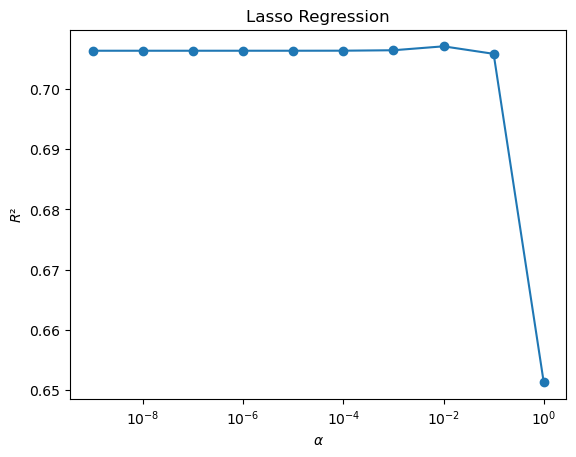

In [14]:
plt.semilogx(alphas, scores, '-o')
plt.title('Lasso Regression')
plt.xlabel('$\\alpha$')
plt.ylabel('$R²$')
plt.show()

### Using PolynomialFeatures

In [15]:
pf = PolynomialFeatures(degree=2)
scores = []
alphas = np.geomspace(0.001, 10, 5)

for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    estimator = Pipeline([("make_higher_degree", pf),
                          ("scaler", s),
                          ("lasso_regression", las)])
    
    predictions = cross_val_predict(estimator, X,y, cv=kf)
    score = r2_score(y, predictions)
    scores.append(score)

scores

[0.8465056899967264,
 0.8552553819994723,
 0.8124536477296069,
 0.7090474482089187,
 -0.000616160136140298]

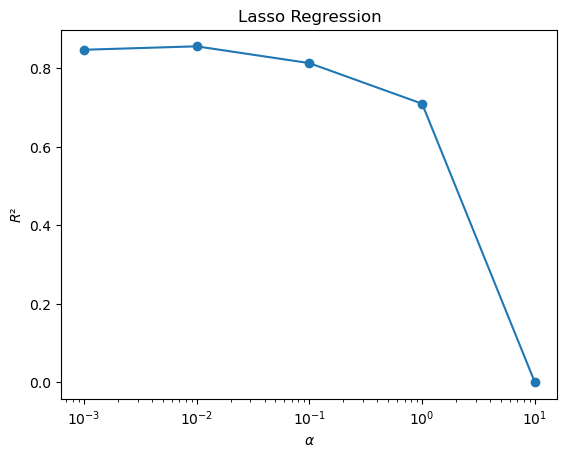

In [16]:
plt.semilogx(alphas, scores, '-o')
plt.title('Lasso Regression')
plt.xlabel('$\\alpha$')
plt.ylabel('$R²$')
plt.show()

In [17]:
# Once we have found the hyperparameter (alpha~1e-2=0.01)
# make the model and train it on ALL the data
# Then release it into the wild .....
best_estimator = Pipeline([('make_higher_degree', PolynomialFeatures(degree=2)),
                           ('scaler', s),
                           ('lasso_regression', Lasso(alpha=0.01, max_iter=100000))])

best_estimator.fit(X,y)
best_estimator.score(X,y)

0.9032551408154241

In [18]:
best_estimator.named_steps['lasso_regression'].coef_

array([ 0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        4.61127587e+00,  0.00000000e+00,  6.24240557e-01,  0.00000000e+00,
       -7.22878514e+00,  9.74968793e+00,  0.00000000e+00,  0.00000000e+00,
        6.34548325e-01,  0.00000000e+00,  9.95741679e-01, -5.51374291e-03,
       -0.00000000e+00,  2.44370838e+00, -2.40444044e+00, -0.00000000e+00,
       -0.00000000e+00, -2.23044443e-01, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -2.88128934e-01,  5.17203914e-01,  3.07715719e-01,
       -3.39853933e-01, -9.86590910e-02, -0.00000000e+00,  2.72847487e-01,
       -0.00000000e+00, -6.39829763e-01, -3.16474346e-01,  1.44555554e+00,
        0.00000000e+00, -0.00000000e+00, -8.84630187e-01,  1.32081558e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  2.63148300e+00,
       -2.62941147e-01,  0.00000000e+00,  9.08410143e-01, -8.17144528e-01,
        0.00000000e+00, -4.31628234e+00,  5.53254405e-01, -2.91912598e+00,
       -4.68486241e+00,  

### Regression Ridge

Which model, Ridge or Lasso, performs best with its optimal hyperparameters on the Boston dataset?



In [19]:
pf = PolynomialFeatures(degree=2)
scores = []
alphas = np.geomspace(4,20,20)

for alpha in alphas:
    ridge = Ridge(alpha=alpha, max_iter=100000)
    estimator = Pipeline([('polynomial_features', pf),
                          ('scaler', s),
                          ('ridge_regression', ridge)])
    
    predictions = cross_val_predict(estimator, X, y, cv=kf)
    score = r2_score(y,predictions)
    scores.append(score)

scores

[0.8542799099367075,
 0.8533435447722383,
 0.8523239993862886,
 0.851216427877795,
 0.8500160637574418,
 0.848718337788122,
 0.847319007171533,
 0.8458142923258459,
 0.8442010166574796,
 0.8424767440382863,
 0.8406399082220848,
 0.8386899282277978,
 0.8366273038238183,
 0.8344536856939685,
 0.8321719156512526,
 0.8297860333680591,
 0.8273012474619004,
 0.8247238703424089,
 0.8220612178978945,
 0.8193214767757384]

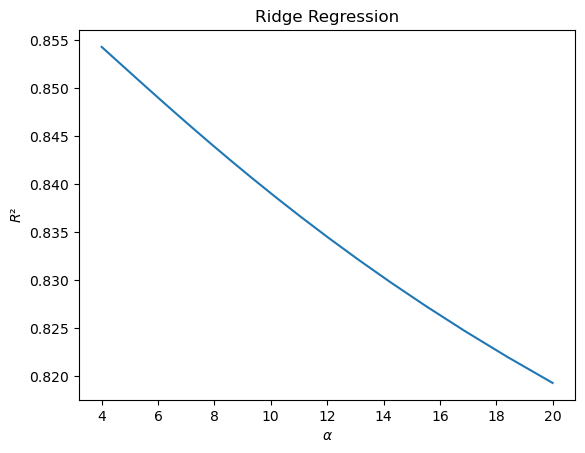

In [20]:
plt.plot(alphas, scores)
plt.title('Ridge Regression')
plt.xlabel('$\\alpha$')
plt.ylabel('$R²$')
plt.show()

**Conclusion**: Both Lasso and Ridge with proper hyperparameter tuning give better results than plain ol' Linear Regression!



In [22]:
# Once we have found the hyperparameter (alpha~1e-2=0.01)
# make the model and train it on ALL the data
# Then release it into the wild .....
best_estimator = Pipeline([('make_higher_degree', PolynomialFeatures(degree=2)),
                           ('scaler', s),
                           ('lasso_regression', Lasso(alpha=0.01, max_iter=100000))])

best_estimator.fit(X,y)
best_estimator.score(X,y)

0.9032551408154241

In [30]:
df_importances = pd.DataFrame(zip(best_estimator.named_steps['make_higher_degree'].get_feature_names_out(),
                                  best_estimator.named_steps['lasso_regression'].coef_))
df_importances.sort_values(by=1)


,0,1
8,DIS,-7.228785
73,RM TAX,-6.677045
52,CHAS RM,-4.684862
94,RAD LSTAT,-4.545681
72,RM RAD,-4.430641
...,...,...
4,CHAS,4.611276
96,TAX PTRATIO,5.129595
104,LSTAT^2,5.635229
69,RM^2,8.594069


In [29]:
col_names_dict = dict(zip(list(range(len(X.columns.values))), X.columns.values))

col_names_dict

{0: 'CRIM',
 1: 'ZN',
 2: 'INDUS',
 3: 'CHAS',
 4: 'NOX',
 5: 'RM',
 6: 'AGE',
 7: 'DIS',
 8: 'RAD',
 9: 'TAX',
 10: 'PTRATIO',
 11: 'B',
 12: 'LSTAT'}

### Grid Search CV

To do cross-validation, we used two techniques:

- use `KFolds` and manually create a loop to do cross-validation
- use `cross_val_predict` and score to get a cross-valiated score in a couple of lines.

To do hyper-parameter tuning, we see a general pattern:

- use `cross_val_predict` and score in a manually written loop over hyperparemeters, then select the best one.

Perhaps not surprisingly, there is a function that does this for us -- `GridSearchCV`

In [34]:
from sklearn.model_selection import GridSearchCV

In [39]:
estimator = Pipeline([('polynomial_features', PolynomialFeatures()),
                      ('scaler', StandardScaler()),
                      ('ridge_regression', Ridge())])


params = {'polynomial_features__degree': [1,2,3],
          'ridge_regression__alpha': np.geomspace(4,20,20)}

grid = GridSearchCV(estimator, params, cv=kf)
grid.fit(X,y)

GridSearchCV(cv=KFold(n_splits=3, random_state=72018, shuffle=True),
             estimator=Pipeline(steps=[('polynomial_features',
                                        PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('ridge_regression', Ridge())]),
             param_grid={'polynomial_features__degree': [1, 2, 3],
                         'ridge_regression__alpha': array([ 4.        ,  4.3535936 ,  4.73844431,  5.15731521,  5.61321363,
        6.10941274,  6.64947505,  7.23727802,  7.87704182,  8.57335972,
        9.331231  , 10.1560969 , 11.05387963, 12.03102491, 13.09454827,
       14.25208539, 15.51194695, 16.88317825, 18.37562421, 20.        ])})

In [45]:
print(grid.best_params_)
print(grid.best_score_)
print('\n')
print("Columnas durante el ajuste: ", grid.best_estimator_.named_steps['polynomial_features'].get_feature_names_out())
print(f'Columnas durante la predicción: {X.columns}')

{'polynomial_features__degree': 2, 'ridge_regression__alpha': 4.0}
0.8546333782070406


Columnas durante el ajuste:  ['1' 'CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX'
 'PTRATIO' 'B' 'LSTAT' 'CRIM^2' 'CRIM ZN' 'CRIM INDUS' 'CRIM CHAS'
 'CRIM NOX' 'CRIM RM' 'CRIM AGE' 'CRIM DIS' 'CRIM RAD' 'CRIM TAX'
 'CRIM PTRATIO' 'CRIM B' 'CRIM LSTAT' 'ZN^2' 'ZN INDUS' 'ZN CHAS' 'ZN NOX'
 'ZN RM' 'ZN AGE' 'ZN DIS' 'ZN RAD' 'ZN TAX' 'ZN PTRATIO' 'ZN B'
 'ZN LSTAT' 'INDUS^2' 'INDUS CHAS' 'INDUS NOX' 'INDUS RM' 'INDUS AGE'
 'INDUS DIS' 'INDUS RAD' 'INDUS TAX' 'INDUS PTRATIO' 'INDUS B'
 'INDUS LSTAT' 'CHAS^2' 'CHAS NOX' 'CHAS RM' 'CHAS AGE' 'CHAS DIS'
 'CHAS RAD' 'CHAS TAX' 'CHAS PTRATIO' 'CHAS B' 'CHAS LSTAT' 'NOX^2'
 'NOX RM' 'NOX AGE' 'NOX DIS' 'NOX RAD' 'NOX TAX' 'NOX PTRATIO' 'NOX B'
 'NOX LSTAT' 'RM^2' 'RM AGE' 'RM DIS' 'RM RAD' 'RM TAX' 'RM PTRATIO'
 'RM B' 'RM LSTAT' 'AGE^2' 'AGE DIS' 'AGE RAD' 'AGE TAX' 'AGE PTRATIO'
 'AGE B' 'AGE LSTAT' 'DIS^2' 'DIS RAD' 'DIS TAX' 'DIS PTRATIO' 

In [46]:
y_predict = grid.predict(X)

# This includes both in-sample and out-of-sample
r2_score(y,y_predict)

0.8964707714558122

In [47]:
# Notice that "grid" is a fit object!
# We can use grid.predict(X_test) to get brand new predictions!
grid.best_estimator_.named_steps['ridge_regression'].coef_

array([ 0.00000000e+00,  2.47147038e-01, -1.18377806e+00,  1.11700133e+00,
        1.02268931e+00,  1.11573592e+00,  2.63515343e+00,  1.60400844e+00,
       -2.44378403e+00,  2.67549673e+00,  1.18120641e+00,  3.00931414e-01,
        7.17164316e-01,  5.46697603e-01,  1.16368605e+00,  2.78583120e-01,
        4.15770986e-01,  2.45396270e+00, -1.07012228e+00, -8.15812777e-01,
       -2.95036466e-01, -8.26480829e-01, -4.23552596e-01, -4.33022591e-02,
        8.34930099e-02, -4.92838202e-01,  5.12447325e-01,  5.88355149e-01,
       -3.50662224e-01, -1.39184102e-01, -2.99737738e-01,  1.02696466e+00,
        1.47705864e-02, -6.87593891e-01, -3.12176710e-01,  1.26476807e+00,
        1.01258007e+00, -5.51925730e-01, -8.62269698e-01,  8.78832853e-01,
        6.75975245e-02,  5.91362874e-01, -1.45086000e+00,  1.09286634e+00,
       -7.69112663e-01,  1.16978387e+00,  1.29460196e+00, -7.36888615e-01,
        7.29205860e-01, -2.44086792e+00,  1.02268931e+00, -2.26162754e+00,
       -2.56091292e+00,  

In [48]:
grid.cv_results_


{'mean_fit_time': array([0.00821678, 0.00752179, 0.00503119, 0.00457104, 0.0105257 ,
        0.0062902 , 0.00605718, 0.00485198, 0.00418448, 0.00439946,
        0.0043335 , 0.00429392, 0.00383377, 0.00396371, 0.00378704,
        0.00402315, 0.00413497, 0.00431983, 0.00448767, 0.00516017,
        0.00636856, 0.00628726, 0.00710432, 0.0071969 , 0.00559227,
        0.00654578, 0.00555873, 0.00680606, 0.00618148, 0.00485182,
        0.0051678 , 0.00464471, 0.00459417, 0.00502197, 0.00527541,
        0.00513172, 0.00500774, 0.00527589, 0.00509342, 0.00558352,
        0.01206406, 0.01152547, 0.01539095, 0.01477528, 0.01197942,
        0.02330438, 0.01243218, 0.01190162, 0.01221045, 0.01216809,
        0.01471122, 0.01278122, 0.01242812, 0.0115095 , 0.01313106,
        0.01320028, 0.01296449, 0.01277137, 0.01323223, 0.01291315]),
 'std_fit_time': array([2.54579255e-03, 1.93119040e-03, 7.37103092e-04, 8.84918070e-05,
        4.86405748e-03, 1.03825660e-03, 2.70497389e-03, 4.65876669e-04,
     